In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# --- Import EfficientNetB0 and its preprocessing ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall # <-- Added Precision and Recall
from tensorflow.keras.optimizers import Adam

# --- CONFIGURATION AND CONSTANTS ---

# Kaggle data path
DATA_DIR = r'/kaggle/input/cancerclassification/Classification/Image'

# --- MODEL CONSTANTS ---
# EfficientNet-B0 default input size is 224x224
IMAGE_SIZE = (224, 224) 
BATCH_SIZE = 64
CLASSES = ['Normal', 'Benign', 'Malignant']
NUM_CLASSES = len(CLASSES)

# --- TRAINING CONSTANTS ---
EPOCHS = 50 # We'll use EarlyStopping, so this is a maximum

In [9]:
def setup_environment():
    """Clears session and configures GPU memory growth and mixed precision."""
    tf.keras.backend.clear_session()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Using {len(gpus)} GPU(s) with memory growth enabled.")
            
            # Enable Mixed Precision (FP16) for VRAM optimization
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            print("Enabled Mixed Precision (float16) policy.")
        except RuntimeError as e:
            print(e)
    else:
        print("No GPU detected. Using CPU.")

# --- FIX 1: Add a 'repeat' parameter to the function ---
def prepare_ds(ds, shuffle=False, repeat=False):
    """Applies EfficientNet preprocessing, batches, and prefetches the dataset."""
    # --- Use the correct preprocessing function ---
    ds = ds.map(lambda x, y: (efficientnet_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    
    # --- FIX 1 (continued): Add the .repeat() call ---
    if repeat:
        ds = ds.repeat() # Makes the dataset loop indefinitely
        
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def load_and_split_data(data_dir, classes, image_size):
    """Loads the full dataset and manually splits it (80/10/10)."""
    print("Loading dataset...")
    full_ds = image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        class_names=classes,
        image_size=image_size,
        interpolation='bilinear',
        batch_size=None, # Load unbatched for splitting
        shuffle=True,
        seed=42
    )
    ds_size = tf.data.experimental.cardinality(full_ds).numpy()

    if ds_size <= 0:
        print(f"Error: No images found in {data_dir}. Dataset size is {ds_size}.")
        return None, None, None, 0

    train_size = int(0.8 * ds_size)
    val_size = int(0.1 * ds_size)
    test_size = ds_size - train_size - val_size # Remainder
    
    train_ds_raw = full_ds.take(train_size)
    val_ds_raw = full_ds.skip(train_size).take(val_size)
    test_ds_raw = full_ds.skip(train_size + val_size)

    print(f"Data split: Total={ds_size}, Train={train_size}, Validation={val_size}, Test={test_size}")
    return train_ds_raw, val_ds_raw, test_ds_raw, ds_size

# --- EXECUTION ---
setup_environment()
train_ds_raw, val_ds_raw, test_ds_raw, ds_size = load_and_split_data(DATA_DIR, CLASSES, IMAGE_SIZE)

if ds_size > 0:
    # --- FIX 2: Update the function calls ---
    train_ds = prepare_ds(train_ds_raw, shuffle=True, repeat=True)
    val_ds = prepare_ds(val_ds_raw, repeat=True)
    test_ds_prepared = prepare_ds(test_ds_raw, repeat=False) # Keep test set finite
    
    # Calculate steps for model.fit()
    train_size = tf.data.experimental.cardinality(train_ds_raw).numpy()
    val_size = tf.data.experimental.cardinality(val_ds_raw).numpy()
    
    STEPS_PER_EPOCH = train_size // BATCH_SIZE
    VALIDATION_STEPS = val_size // BATCH_SIZE
    
    if STEPS_PER_EPOCH == 0: STEPS_PER_EPOCH = 1
    if VALIDATION_STEPS == 0: VALIDATION_STEPS = 1
    
    print(f"Calculated steps: STEPS_PER_EPOCH={STEPS_PER_EPOCH}, VALIDATION_STEPS={VALIDATION_STEPS}")
else:
    print("Skipping data preparation as no data was loaded.")

Using 2 GPU(s) with memory growth enabled.
Enabled Mixed Precision (float16) policy.
Loading dataset...
Found 1665 files belonging to 3 classes.
Data split: Total=1665, Train=1332, Validation=166, Test=167
Calculated steps: STEPS_PER_EPOCH=20, VALIDATION_STEPS=2


In [10]:
def build_base_model(image_size, num_classes):
    """Builds a base EfficientNet-B0 model for transfer learning."""
    
    # 1. Load EfficientNet-B0 with ImageNet weights, excluding the top layer
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=image_size + (3,)
    )
    
    # 2. Freeze the base model
    base_model.trainable = False
    
    # 3. Create the new model on top
    inputs = Input(shape=image_size + (3,))
    
    # Pass input through the base model
    x = base_model(inputs, training=False)
    
    # Add our own classifier head
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x) # A light dropout for regularization
    
    # Final layer
    # Use 'softmax' activation and 'float32' dtype for stability with mixed precision
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    model = Model(inputs, outputs)
    return model

if ds_size > 0:
    model = build_base_model(IMAGE_SIZE, NUM_CLASSES)
    model.summary()
else:
    print("Skipping model building as no data was loaded.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
if ds_size > 0:
    print("\n--- Starting Model Training ---")
    
    # Callbacks
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=5, # Stop after 5 epochs of no improvement
        restore_best_weights=True
    )
    
    checkpoint_callback = ModelCheckpoint(
        filepath='efficientnetb0_base_best.weights.h5', # <-- Changed filename
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001), # Adam is a good default
        loss='categorical_crossentropy',    # Standard loss for softmax
        metrics=[
            'accuracy', 
            Precision(name='val_precision'), # Track Precision
            Recall(name='val_recall')      # Track Recall
        ]
    )
    
    # Train
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        callbacks=[early_stopping_callback, checkpoint_callback]
    )
    
    print("\n--- Training Complete ---")
    
else:
    print("Skipping training as no data was loaded.")


--- Starting Model Training ---
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5098 - loss: 1.0137 - val_precision: 0.5787 - val_recall: 0.2733
Epoch 1: val_loss improved from inf to 0.85479, saving model to efficientnetb0_base_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 983ms/step - accuracy: 0.5117 - loss: 1.0114 - val_precision: 0.5807 - val_recall: 0.2780 - val_accuracy: 0.6172 - val_loss: 0.8548 - val_val_precision: 0.7191 - val_val_recall: 0.5000
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6185 - loss: 0.8219 - val_precision: 0.6937 - val_recall: 0.5292
Epoch 2: val_loss improved from 0.85479 to 0.73644, saving model to efficientnetb0_base_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 822ms/step - accuracy: 0.6192 - loss: 0.8212 - val_precision: 0.6941 - val_recall: 0.5290 - val_accuracy: 0.6719 - val_loss: 0.7364 - val_val_precision: 0.8353 - val_val_recall: 0.5547
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.663


--- Loading best weights for final evaluation ---

--- Final Evaluation on Test Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7366 - loss: 0.6067 - val_precision: 0.7729 - val_recall: 0.6487

Test Loss: 0.5927
Test Accuracy: 0.7545
Test Precision: 0.7929
Test Recall: 0.6647
Gathering predictions and labels (single-pass)...
Gathering complete.

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

      Normal       0.73      0.84      0.78        44
      Benign       0.81      0.78      0.79        74
   Malignant       0.77      0.69      0.73        49

    accuracy                           0.77       167
   macro avg       0.77      0.77      0.77       167
weighted avg       0.77      0.77      0.77       167


--- Generating Plots ---


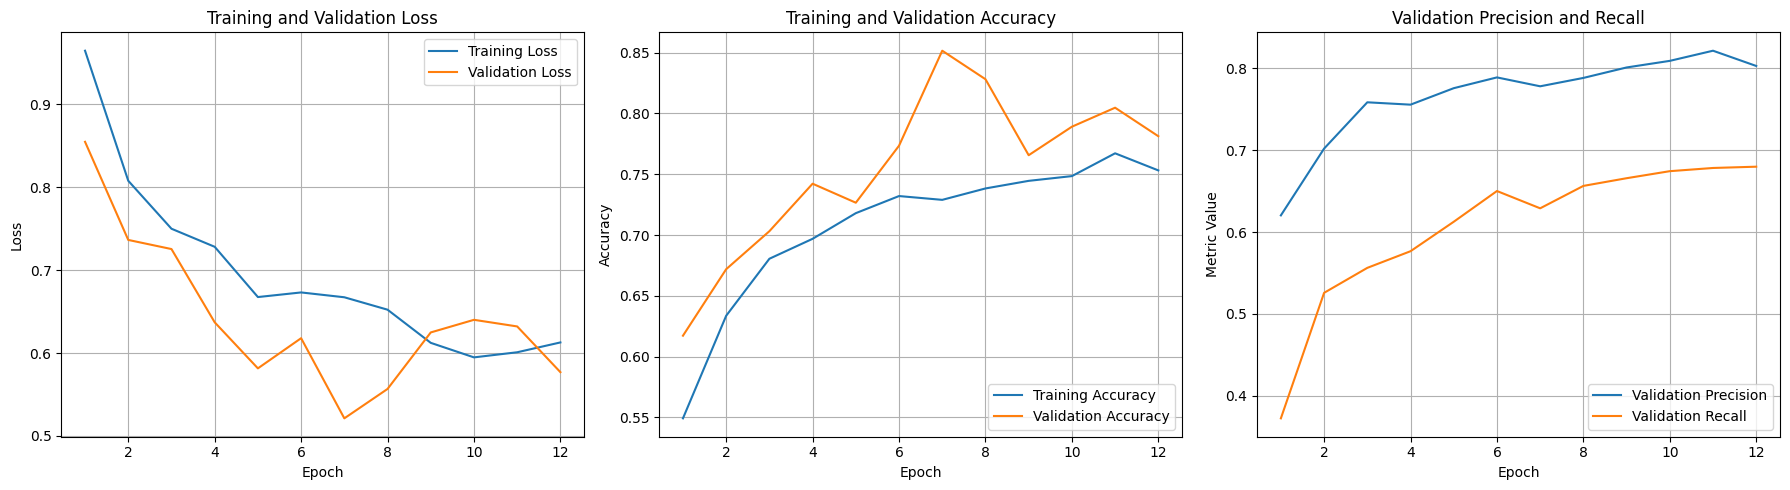

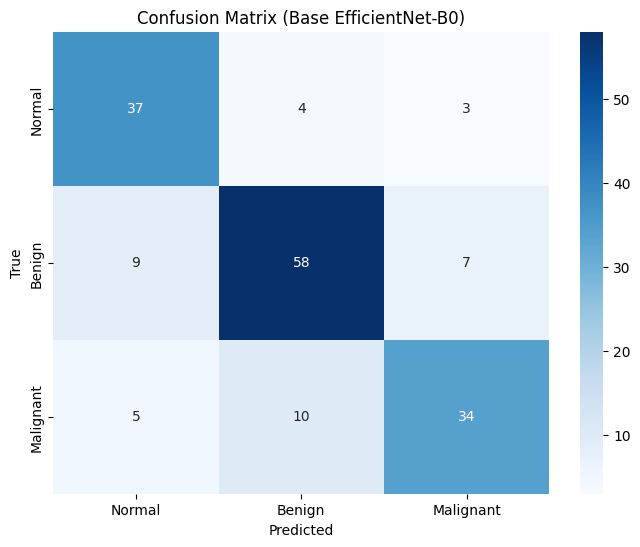

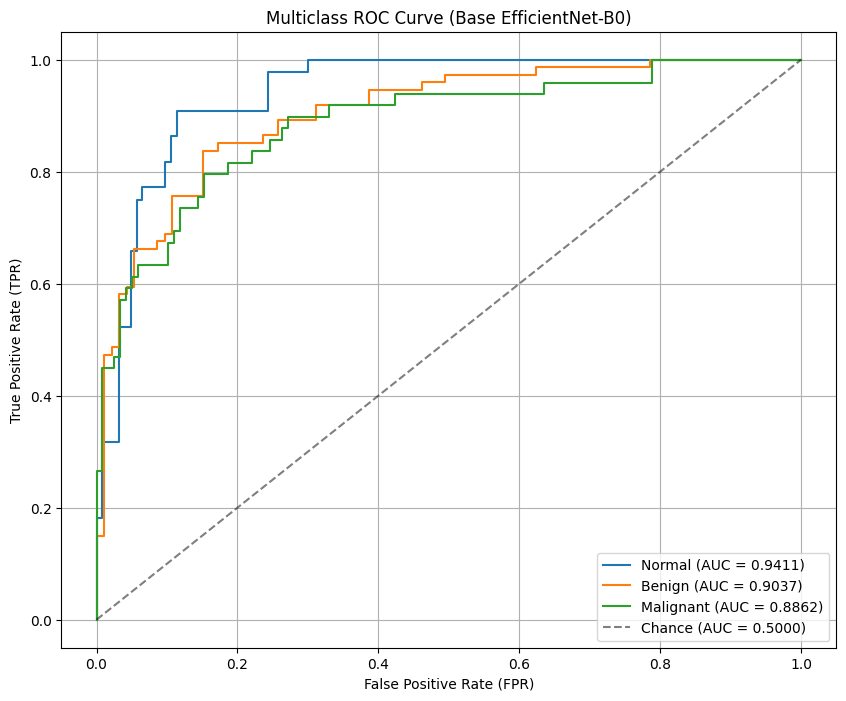

In [12]:
# --- (HELPER FUNCTIONS - Corrected from previous notebook) ---

def get_predictions_and_labels(test_ds_prepared, model):
    """
    Collects true labels and predictions by iterating over the 
    prepared dataset *once* to prevent a shuffle mismatch.
    """
    print("Gathering predictions and labels (single-pass)...")
    y_true_list = []
    y_pred_probs_list = []
    
    for images, labels in test_ds_prepared:
        y_true_list.append(labels.numpy())
        y_pred_logits = model(images, training=False)
        y_pred_probs_list.append(tf.nn.softmax(y_pred_logits).numpy())

    y_true_one_hot = np.concatenate(y_true_list, axis=0)
    y_pred_probs = np.concatenate(y_pred_probs_list, axis=0)

    y_true = np.argmax(y_true_one_hot, axis=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    print("Gathering complete.")
    return y_true, y_pred_probs, y_pred

def plot_learning_curves(history):
    """
    Plots training & validation loss, accuracy, precision, and recall
    from a single history object.
    """
    if not history or not history.history:
        print("History object is empty. Skipping plotting.")
        return
        
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # 1. Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, hist['loss'], label='Training Loss')
    plt.plot(epochs, hist['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # 2. Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, hist['accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # 3. Plot Precision and Recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs, hist['val_precision'], label='Validation Precision')
    plt.plot(epochs, hist['val_recall'], label='Validation Recall')
    plt.title('Validation Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("efficientnetb0_base_learning_curves.png") # <-- Changed filename
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Base EfficientNet-B0)") # <-- Changed title
    plt.savefig("efficientnetb0_base_confusion_matrix.png") # <-- Changed filename
    plt.show()

def plot_roc_curve(y_true_raw, y_pred_probs, classes):
    """Plots the Multiclass ROC Curve (One-vs-Rest)."""
    y_true_one_hot = to_categorical(y_true_raw, num_classes=NUM_CLASSES)
    
    plt.figure(figsize=(10, 8))
    
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc = roc_auc_score(y_true_one_hot[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.4f})')
        
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5000)', alpha=0.5)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Multiclass ROC Curve (Base EfficientNet-B0)') # <-- Changed title
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig("efficientnetb0_base_roc_curve.png") # <-- Changed filename
    plt.show()

# --- FINAL EVALUATION EXECUTION ---
if ds_size > 0:
    print("\n--- Loading best weights for final evaluation ---")
    
    # Load the best weights saved by the checkpoint
    model.load_weights('efficientnetb0_base_best.weights.h5') # <-- Changed filename
    
    print("\n--- Final Evaluation on Test Set ---")
    test_results = model.evaluate(test_ds_prepared, verbose=1)
    
    print(f"\nTest Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")
    print(f"Test Precision: {test_results[2]:.4f}")
    print(f"Test Recall: {test_results[3]:.4f}")

    # Get predictions for plots and report
    y_true, y_pred_probs, y_pred = get_predictions_and_labels(test_ds_prepared, model)
    
    if y_true.size > 0:
        print("\n--- Classification Report (Test Set) ---")
        # This report will show you the Precision and Recall for each class
        print(classification_report(y_true, y_pred, target_names=CLASSES))
        
        # --- Generate All Plots ---
        print("\n--- Generating Plots ---")
        plot_learning_curves(history)
        plot_confusion_matrix(y_true, y_pred, CLASSES)
        plot_roc_curve(y_true, y_pred_probs, CLASSES)
    else:
        print("Skipping report and plots due to prediction error.")
else:
    print("\nSkipping final evaluation and plotting.")